In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
plt.style.use('seaborn')

/kaggle/input/vehicle-dataset-from-cardekho/car data.csv
/kaggle/input/vehicle-dataset-from-cardekho/CAR DETAILS FROM CAR DEKHO.csv
/kaggle/input/vehicle-dataset-from-cardekho/Car details v3.csv


## **1. Understanding the Dataset**

In [2]:
df=pd.read_csv('/kaggle/input/vehicle-dataset-from-cardekho/car data.csv')

In [3]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [4]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [5]:
df.columns

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner'],
      dtype='object')

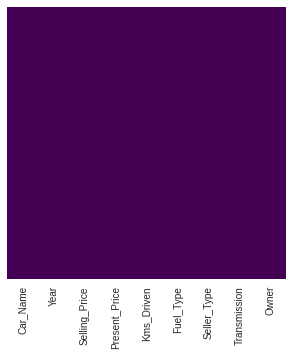

In [6]:
# Visualising Missing Values
plt.figure(figsize=[5,5])
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

So we have no missing values in any column

In [7]:
# creating a new column named 'Age' to know how old the car is
df['Age']=2020-df['Year']

In [8]:
df.drop('Year',axis=1,inplace=True)

## **2. Exploratory Data Analysis**

### **Univariate Analysis**

#### Categorical Features Visualisation

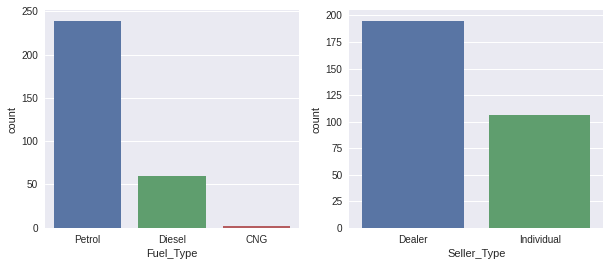

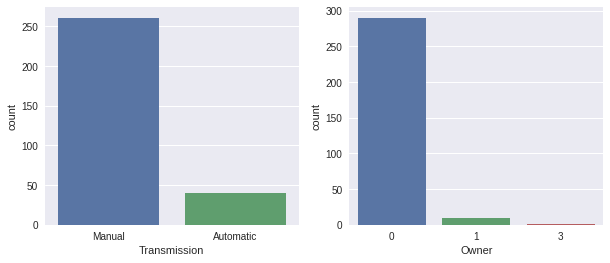

In [9]:
categ_cols=['Fuel_Type', 'Seller_Type', 'Transmission', 'Owner']
i=0
while i < 4:
    fig = plt.figure(figsize=[10,4])
    plt.subplot(1,2,1)
    sns.countplot(x=categ_cols[i], data=df)
    i += 1
    plt.subplot(1,2,2)
    sns.countplot(x=categ_cols[i], data=df)
    i += 1
    
    plt.show()

#### Numerical features to visualise outliers

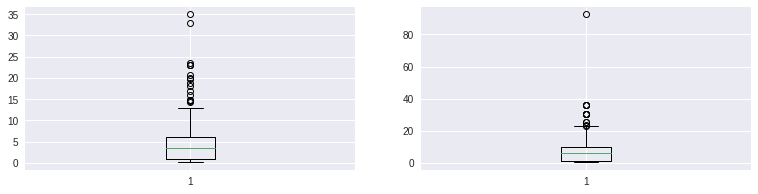

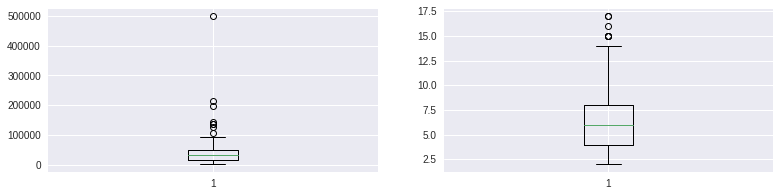

In [10]:
num_cols=['Selling_Price', 'Present_Price', 'Kms_Driven','Age']
i=0 
while(i<4):
    plt.figure(figsize=[13,3])
    plt.subplot(1,2,1)
    plt.boxplot(x=num_cols[i],data=df)
    i+=1
    plt.subplot(1,2,2)
    plt.boxplot(x=num_cols[i],data=df)
    i+=1
    plt.show()

### **Bivariate Analysis**

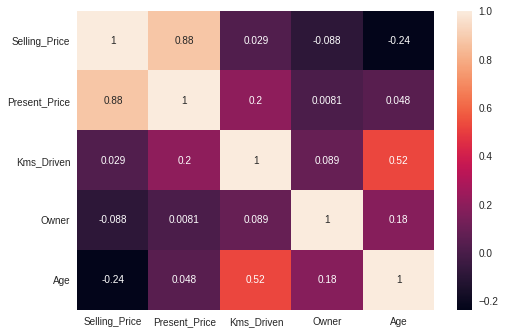

In [11]:
sns.heatmap(df.corr(),annot=True)

* Selling Price of a car is more correlated with Present Price
* Selling Price is also correlated with the Age of car

## **3. Data Preparation**

### **One-Hot Encoding for categorical features**

In [12]:
# dropping CarName as it has no effect in our model to predict the price
df.drop('Car_Name',axis=1,inplace=True)

In [13]:
# creating dummy variables and dropping first to avoid dummy variable trap
df=pd.get_dummies(data=df,drop_first=True)

### Performing Train-Test Split

In [14]:
from sklearn.model_selection import train_test_split
y=df['Selling_Price']
x=df.drop('Selling_Price',axis=1)

In [15]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (210, 8)
x test:  (91, 8)
y train:  (210,)
y test:  (91,)


## **4. Model Building**

In [16]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import pickle

In [17]:
cv=[]
r2=[]
def regg_model(model,model_name):
    model.fit(x_train,y_train)
    
    # r2-score
    y_pred=model.predict(x_test)
    r2.append(r2_score(y_test,y_pred))
    
    # cross-val-score
    cross_val=cross_val_score(model,x_train,y_train,cv=5)
    cross_val_mean=cross_val.mean()
    print('R2-Score: ',r2)
    print('Cross-Val-Mean-Score: ',cross_val_mean)
    
    # dumping model in a pickle file
    model_path='./car-models'+ model_name
    file=open(model_path,'wb')
    pickle.dump(model,file)

### 1. Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
regg_model(lr,'LinearRegeression.pkl')

R2-Score:  [0.8328677177266117]
Cross-Val-Mean-Score:  0.8624358639145218


### 2. Random Forest

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf=RandomForestRegressor()

# number of trees
n_estimators=list(range(500,1000,100))
# Maximum depth of tree
max_depth=list(range(4,9,4))
# Minimum samples to split internal node
min_samples_split=list(range(4,9,2))
# Minimum samples to be a leaf node
min_samples_leaf=[1,2,5,7]
# features considered at each split
max_features=['auto','sqrt']

# Hyperparameters
params={'n_estimators':n_estimators,
       'max_depth':max_depth,
       'min_samples':min_samples_split,
       'min_samples_leaf':min_samples_leaf,
       'max_features':max_features}

rf_rs=RandomizedSearchCV(estimator=rf,param_distributions=params)

In [20]:
regg_model(rf,'Random_Forest.pkl')

R2-Score:  [0.8328677177266117, 0.9262819981906862]
Cross-Val-Mean-Score:  0.9068145409642728


### 3. Gradient Boosting

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

gb = GradientBoostingRegressor()

# Rate at which correcting is being made
learning_rate = [0.001, 0.01, 0.1, 0.2]
# Number of trees in Gradient boosting
n_estimators=list(range(500,1000,100))
# Maximum number of levels in a tree
max_depth=list(range(4,9,4))
# Minimum number of samples required to split an internal node
min_samples_split=list(range(4,9,2))
# Minimum number of samples required to be at a leaf node.
min_samples_leaf=[1,2,5,7]
# Number of fearures to be considered at each split
max_features=['auto','sqrt']

# Hyperparameters dict
params = {"learning_rate":learning_rate,
              "n_estimators":n_estimators,
              "max_depth":max_depth,
              "min_samples_split":min_samples_split,
              "min_samples_leaf":min_samples_leaf,
              "max_features":max_features}

gb_rs = RandomizedSearchCV(estimator = gb, param_distributions = params)

In [22]:
regg_model(gb_rs,'gradient_boosting.pkl')

R2-Score:  [0.8328677177266117, 0.9262819981906862, 0.9404921440101517]
Cross-Val-Mean-Score:  0.9025966047685718


**Checking Pickle file**

In [23]:
model=pickle.load(open('./car-modelsgradient_boosting.pkl','rb'))
type(model)

sklearn.model_selection._search.RandomizedSearchCV

In [24]:
model.predict(x_test.head())

array([ 1.13577633, 10.36732531,  8.79508329,  5.15961874,  0.16998546])

In [25]:
open('./car-modelsgradient_boosting.pkl','rb').close()